In [86]:
from psaw import PushshiftAPI
import praw
from prawcore import Forbidden
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import seaborn as sns

from scipy import stats

from pymongo import MongoClient, errors
from bson.json_util import loads, dumps
from bson.objectid import ObjectId

from datetime import datetime as dt

import boto3

import time

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, roc_curve, auc, roc_auc_score
from sklearn.metrics import plot_confusion_matrix

from imblearn.ensemble import BalancedRandomForestClassifier

from scipy import interp

import string

In [2]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /home/ubuntu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/ubuntu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/ubuntu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
porter = PorterStemmer()
wordnet = WordNetLemmatizer()

In [4]:
client = MongoClient('localhost', 27017)
db = client['cap2']

In [5]:
# get all comments into a list called 'docs', then make dataframe
query = {}
fields = { '_id': 0 }
# docs is about 1.3 GB in RAM
docs = list(db['comment'].find( query, fields ))

In [6]:
comms = pd.DataFrame(docs)

In [ ]:
# TODO add submission ids to the set of ids from trolls, probably append 't1_' to comments
# for ease of use

## assign labels, 'troll?', and 'child_of_troll?', and 'parent_of_troll?'

In [71]:
# create array of classes for target
classes = ['other', 'parent', 'child', 'troll']

In [7]:
# assign the label, 'troll?'' to each comment
troll_comment_ids_set = set(comms[~comms['author'].isna()]['id'])
comms['troll?'] = [int(mybool) for mybool in [
                    commid in troll_comment_ids_set for commid in comms['id']
                    ]]
np.sum(comms['troll?'])

6704

In [8]:
# is this comment in reply to a troll?
comms['child_of_troll?'] = [int(mybool) for mybool in [
                    pid.split('_')[1] in troll_comment_ids_set for pid in comms['parent_id']
                    ]]
np.sum(comms['child_of_troll?'])

57

## only 57, that can't be correct

In [9]:
# did a troll reply to this?
troll_parent_ids_set = set(
                            [p.split('_')[1] for p in comms[~comms['author'].isna()]['parent_id']]
                        )
comms['parent_of_troll?'] = [int(mybool) for mybool in [
                    parentid.split('_')[1] in troll_parent_ids_set for parentid in comms['parent_id']
                    ]]
np.sum(comms['parent_of_troll?'])

219019

In [111]:
def pick_class(df):
    newcol = np.array(['other'] * len(df), )
    newcol[df['parent_of_troll?']==1] = 'parent'
    newcol[df['child_of_troll?']==1] = 'child'
    newcol[df['troll?']==1] = 'troll'
    df['class_label'] = pd.Series(newcol)

In [59]:
comms.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230853 entries, 0 to 230852
Data columns (total 75 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   author                           6704 non-null    object 
 1   author_created_utc               6597 non-null    float64
 2   author_flair_css_class           57434 non-null   object 
 3   author_flair_text                58619 non-null   object 
 4   author_fullname                  201891 non-null  object 
 5   body                             230853 non-null  object 
 6   controversiality                 230219 non-null  float64
 7   created_utc                      230853 non-null  float64
 8   distinguished                    380 non-null     object 
 9   gilded                           230215 non-null  float64
 10  id                               230853 non-null  object 
 11  link_id                          230853 non-null  object 
 12  ne

## NLP

In [11]:
orig_stopwords_ = set("a,able,about,across,after,all,almost,also,am,among,an,and,any,\
are,as,at,be,because,been,but,by,can,could,dear,did,do,does,either,\
else,ever,every,for,from,get,got,had,has,have,he,her,hers,him,his,\
how,however,i,if,in,into,is,it,its,just,least,let,like,likely,may,\
me,might,most,must,my,neither,no,of,off,often,on,only,or,other,our,\
own,rather,said,say,says,she,should,since,so,some,than,that,the,their,\
them,then,there,these,they,this,tis,to,too,twas,us,wants,was,we,were,\
what,when,where,which,while,who,whom,why,will,with,would,yet,you,your,u,s".split(','))

# new stopwords after first run through
# sws_to_add_brf1 = 'thanks,op,tie,deleted,game,crypto,invest,\
# edit,platform,play,giveaway,ok,yeah,blockchain,enter,remove,\
# m,token,awesome,ethereum,exchange,steam,dude'.split(',')

# stopwords_ = set(list(orig_stopwords_) + sws_to_add_brf1)
stopwords_ = orig_stopwords_

punctuation_ = set(string.punctuation + '’' + '“')

def rm_punctuation(a_string):
    table = str.maketrans('', '', ''.join(punctuation_))
    return a_string.translate(table)
        
def tokens_lower(tokens):
    return [word.lower() for word in tokens]

def filter_tokens(tokens):
#     for w in sent: print(w)
#     if w == "’": print("this is ': " + w)
    return [w for w in tokens if not w in stopwords_]

def stem_tokens(ntlk_stem_obj, tokens):
    # visualize what stemming and lemmitization does!
    # str(porter.__class__) = "<class 'nltk.stem.porter.PorterStemmer'>"
#     name = str(ntlk_stem_lemm_obj.__class__).split("'")[1].split('.')[-1]
#     count_ident = 0
#     count_alter = 0
    return [ntlk_stem_obj.stem(tok) for tok in tokens]
#     elif ''
# for tok in tokens:
#         return ntlk_stem_lemm_obj.stem(tok)
#         if tok == stem_lemm_f_l_tok:
#             count_ident += 1
#         else:
#             print(tok, stem_lemm_f_l_tok)
#             count_alter += 1
#     print('{}:\nNumber of unchanged words: {}\nchanged words: {}\n'.format(name, count_ident, count_alter))

def lemm_tokens(ntlk_lemm_obj, tokens):
    return [ntlk_lemm_obj.lemmatize(tok) for tok in tokens]

In [12]:
def nlp_pre_proc_doc(input_string, stemming=False):
    '''
    given document:
        tokenizes the document
        sets tokens to lower case
        filters punctuation and stop words from tokens
        returns porter, snowball, and wordnet stem/lemm tokens
    '''
    no_punct_string = rm_punctuation(input_string)
    tokens = word_tokenize(no_punct_string)
    lo_tokens = tokens_lower(tokens)
    f_lo_tokens = filter_tokens(lo_tokens)
    if stemming:
        s_f_lo_tokens = stem_tokens(porter, f_lo_tokens)
        le_s_f_lo_tokens = lemm_tokens(wordnet, s_f_lo_tokens)
        return ' '.join(le_s_f_lo_tokens)
    else:
        le_f_lo_tokens = lemm_tokens(wordnet, f_lo_tokens)
        return ' '.join(le_f_lo_tokens)

In [13]:
# this takes a few minutes, and uses about 100 MB of RAM
corpus = [nlp_pre_proc_doc(d) for d in comms['body']]

## Train classifier(s)

In [17]:
# keep a dictionary of trained classifiers for comparison
clfs = {}

### train test split

In [61]:
X_train_corp, X_test_corp, y_train, y_test = train_test_split(
        corpus, y, test_size=0.2, random_state=30, shuffle=True)

In [62]:
n_features = 5000

tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,
                                   max_features=n_features,
                                   stop_words='english')

In [63]:
t0 = time.time()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_corp)
print("done in %0.3fs." % (time.time() - t0))

done in 2.828s.


In [64]:
X_test_tfidf = tfidf_vectorizer.transform(X_test_corp)

In [65]:
X_train = X_train_tfidf.toarray()
X_test = X_test_tfidf.toarray()

In [66]:
# fit the model
# at first I did 100 estimators, but 100*25 is only 2500 
#  whereas we have 5000 features in tfidf. Increase to 400
model_param = {'n_estimators': 400,
                   'max_depth': 5,
                   'max_features': 25,
                   'oob_score': True,
                   'n_jobs': -1,
                   'random_state': 30}

In [88]:
brf = RandomForestClassifier(**model_param, class_weight='balanced_subsample')
brf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight='balanced_subsample', criterion='gini',
                       max_depth=5, max_features=25, max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=400, n_jobs=-1, oob_score=True,
                       random_state=30, verbose=0, warm_start=False)

In [96]:
imbrf = BalancedRandomForestClassifier(**model_param, class_weight='balanced_subsample')
imbrf.fit(X_train, y_train)

/home/ubuntu/miniconda3/envs/ipy/lib/python3.8/site-packages/imblearn/ensemble/_forest.py:591: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


BalancedRandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                               class_weight='balanced_subsample',
                               criterion='gini', max_depth=5, max_features=25,
                               max_leaf_nodes=None, max_samples=None,
                               min_impurity_decrease=0.0, min_samples_leaf=2,
                               min_samples_split=2,
                               min_weight_fraction_leaf=0.0, n_estimators=400,
                               n_jobs=-1, oob_score=True, random_state=30,
                               replacement=False, sampling_strategy='auto',
                               verbose=0, warm_start=False)

## model inspection

In [27]:
def standard_confusion_matrix(y_true, y_predict):
    """
    y_true = [1, 1, 1, 1, 1, 0, 0]

    y_predict = [1, 1, 1, 1, 0, 0, 0]

    In [1]: standard_confusion_matrix(y_true, y_predict)
    >> array([[4., 1.],
    >>       [0., 2.]])
    """
    cm = np.zeros((2,2))
    X = np.array([y_true, y_predict])
    values, counts = np.unique(X, axis=1, return_counts=True)
    for i, v in enumerate(values.T):
        cm[tuple([1, 1] - v)] = counts[i]
    return cm.T.astype(int)

# from the lecture
# Just handy function to make our confusion matrix pretty 
def plot_confusion_matrix(cm, # confusion matrix
                          classes_x, # test to describe what the output of the classes may be (commonly 1 or 0)
                          classes_y,
                          normalize=False, 
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes_x))
    plt.xticks(tick_marks, classes_x, rotation=45)
    plt.yticks(tick_marks, classes_y)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i,  format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Predicted label')
    plt.xlabel('True label')

In [83]:
def plot_roc_nofit(ax, X_test, y_test, clf, clf_name, **kwargs):
    y_prob = np.zeros((len(y_test),2))
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    all_tpr = []
    # Predict probabilities, not classes
    y_prob = clf.predict_proba(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, y_prob[:, 1])
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    if len(ax.lines) == 0:
        plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Random')
    ax.plot(fpr, tpr, lw=1, label='%s (area = %0.2f)' % (clf_name, roc_auc))
    mean_tpr /= 1
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
#     plt.plot(mean_fpr, mean_tpr, 'k--',label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right", )

In [28]:
# include the model for comparisons
clfs['Balanced_RF'] = brf

Confusion matrix, without normalization
[[ 1207   794   403]
 [11388 22978  8066]
 [  253   539   543]]
Normalized confusion matrix
[[0.5  0.33 0.17]
 [0.27 0.54 0.19]
 [0.19 0.4  0.41]]


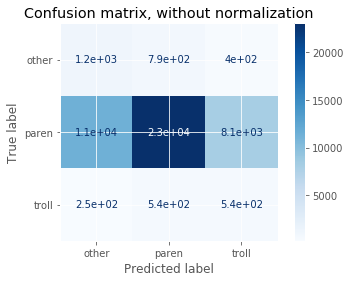

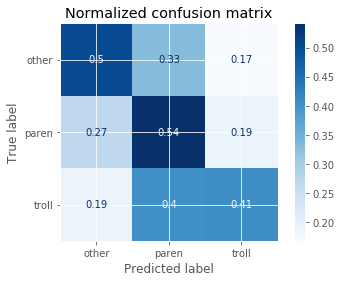

In [95]:
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(brf, X_test, y_test,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

In [84]:
clfs.items()

dict_items([('Balanced_RF', RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight='balanced_subsample', criterion='gini',
                       max_depth=5, max_features=25, max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=400, n_jobs=-1, oob_score=True,
                       random_state=30, verbose=0, warm_start=False))])

TypeError: list indices must be integers or slices, not tuple

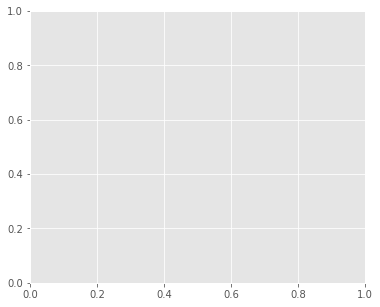

In [85]:
# rnd_smp = np.random.random_sample(len(X)) < 0.
#fig, ax = plt.subplots(1, figsize=(6, 5))
#classifier_labels = ['Random_Forest (RF)', 'Balanced_RF']
#classifiers = {'Random_Forest (RF)': rf, 'Balanced_RF': brf}
#for label, clf in clfs.items():
    #plot_roc_nofit(ax, X_test, y_test, clf, label)
    #multi_class='ovo'
>>> import numpy as np
>>> from sklearn.metrics import roc_auc_score
>>> y_true = np.array([0, 0, 1, 1])
>>> y_scores = np.array([0.1, 0.4, 0.35, 0.8])
>>> roc_auc_score(y_true, y_scores)

In [87]:
brf.predict_proba(X_test)

array([[0.33, 0.33, 0.33],
       [0.32, 0.32, 0.35],
       [0.33, 0.33, 0.33],
       ...,
       [0.34, 0.33, 0.33],
       [0.33, 0.33, 0.34],
       [0.33, 0.33, 0.33]])

In [131]:
troll_comments = comms[comms['troll?']==1]

In [132]:
len(troll_comments)

6704

In [133]:
# let's get the ids for all the troll_comments, then retrieve all the replies to it from Pushshift
troll_comments['id']

0       d4qvapg
1       d4quowa
2       d4queet
3       d4qu1y2
4       d45sina
         ...   
6699    cr9am58
6700    cqv2a2n
6701    cquhx8m
6702    cqt2nku
6703    cpe9ci5
Name: id, Length: 6704, dtype: object

In [124]:
api = PushshiftAPI()

In [140]:
gen = api.search_comments(parent_id='t1_dr3b6ce,t1_cpe9ci5')

In [141]:
next(gen).d_

{'author': 'alritem8',
 'author_created_utc': 1387085510,
 'author_flair_css_class': None,
 'author_flair_text': None,
 'body': "Preet Bharara introduced some doubts about whether or not Flynn is actually cooperating. I personally lean towards believing he is still, but I'm just letting you know it's not necessarily a definite thing right now and we shouldn't be complacent and expect the game to end so soon. You should listen to preet's podcast if you haven't already",
 'created_utc': 1513013289,
 'gildings': {'gid_1': 0, 'gid_2': 0, 'gid_3': 0},
 'id': 'dr3d93z',
 'link_id': 't3_7j34v0',
 'parent_id': 't1_dr3b6ce',
 'permalink': '/r/politics/comments/7j34v0/report_suggests_trump_told_flynn_to_lie_to_the_fbi/dr3d93z/',
 'retrieved_on': 1513013290,
 'score': 1,
 'stickied': False,
 'subreddit': 'politics',
 'subreddit_id': 't5_2cneq',
 'created': 1513013289.0}

In [142]:
next(gen).d_

StopIteration: 

### PushshiftAPI will give us all the responses to the trolls. Get those, asap. praw only gave us comments above the depth of the trolls

#### so, let's recap the tomfoolery between praw and psaw
0) psaw returns comments from trolls, praw does not ... true?
1) psaw returns nothing when searching on threads with comments from trolls ... true? mostly. I believe it's not 100%, but e.g. https://api.pushshift.io/reddit/submission/comment_ids/4rdu5x returns []
2) re: 1, reddit does, but does not include any responses to the trolls ... true?

#### TODO
* classify on pca / increase the number of maximum features per tree
* get user link and comment karma (DONE - https://old.reddit.com/r/pushshift/comments/9i8s23/dataset_metadata_for_69_million_reddit_users_in/)
* how to get the permalink for each comment, what is the subreddit given the id of the post? e.g. t5_2cneq is politics
* what is the author given its id? e.g. t2_105z8m
* is their greater controversiality in troll comments than others?
* get nest_level for everything
* one-hot encode the subreddit to add to the tfidf
* ditch the tfidf and classify using the weights of the topics from NMF
* add user activity profile to the tfidf
* start with id, (comment)
  - is the comment trollish? proba > threshold
  - if yes, then 
    - classify all other comments from the user (max=1000?)
    - for each trollish comment, recurse on other trollish comments in its thread (max=1000?)
  - given all the comments (including non-trollish from threads), view the author creation date and test for spike

In [130]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    troll_comments = comms[comms['troll?']==1]
    print(troll_comments[troll_comments['subreddit']=='politics'])
# comms.tail().iloc[0, :]

                   author  author_created_utc author_flair_css_class  \
408           BlackToLive        1.467681e+09                   None   
409           BlackToLive        1.467681e+09                   None   
410           BlackToLive        1.467681e+09                   None   
436               deusXYX        1.470449e+09                   None   
439               deusXYX        1.470449e+09                   None   
448               deusXYX        1.470449e+09                   None   
452               deusXYX        1.470449e+09                   None   
479               deusXYX        1.470449e+09                   None   
480               deusXYX        1.470449e+09                   None   
481               deusXYX        1.470449e+09                   None   
488               deusXYX        1.470449e+09                   None   
496               deusXYX        1.470449e+09                   None   
499               deusXYX        1.470449e+09                   

In [101]:
y = comms['class_label'].values
np.unique(y, return_counts=True)

(array(['other', 'paren', 'troll'], dtype=object),
 array([ 11834, 212315,   6704]))

In [147]:
dict(zip(comms['subreddit_id'], comms['subreddit']))

{'t5_2qhma': nan,
 't5_3b44e': nan,
 't5_38unr': 'The_Donald',
 't5_2u7i2': 'european',
 't5_2qh13': nan,
 't5_2qh1e': nan,
 't5_2qqdb': nan,
 't5_2qm21': nan,
 't5_2qh33': nan,
 't5_2qzb6': nan,
 't5_2qh1i': nan,
 't5_2wlj3': nan,
 't5_3nmqy': nan,
 't5_2r9sg': nan,
 't5_ga8n6': 'icocrypto2018',
 't5_a50q1': nan,
 't5_4br49': nan,
 't5_2ywp2': nan,
 't5_bdra7': 'NewsWhatever',
 't5_4cyr4': 'bprogramming',
 't5_2z2wm': nan,
 't5_2s3qj': nan,
 't5_2qhij': nan,
 't5_3lgio': nan,
 't5_39m7n': nan,
 't5_39h2c': nan,
 't5_2qh4n': nan,
 't5_3j44v': 'ETHInsider',
 't5_3l6gc': nan,
 't5_3g1ow': nan,
 't5_3clf5': 'ethinvestor',
 't5_aedjj': 'CryptoDoubleOrNothing',
 't5_3oe7n': nan,
 't5_2qian': 'Database',
 't5_2wlmc': nan,
 't5_2uyxv': nan,
 't5_9ocqj': nan,
 't5_3j3sq': nan,
 't5_3nvql': nan,
 't5_2fwo': nan,
 't5_34h22': nan,
 't5_2si5v': nan,
 't5_304ot': 'BTCNews',
 't5_2ruj5': nan,
 't5_3nvbp': 'BrobotTech',
 't5_37jgj': nan,
 't5_2zf9m': nan,
 't5_2t9ha': nan,
 't5_35e7q': nan,
 't5_3no

In [148]:
# np.unique(comms['subreddit_id'] + '_' + comms['subreddit'], return_counts=True)
comms['subreddit_id']

0         t5_2qhma
1         t5_2qhma
2         t5_2qhma
3         t5_2qhma
4         t5_2qhma
            ...   
230848    t5_2qh1a
230849    t5_2qh1a
230850    t5_2qh1a
230851    t5_2qh1a
230852    t5_2qh1a
Name: subreddit_id, Length: 230853, dtype: object

#### join the [71.6 million usernames](https://old.reddit.com/r/pushshift/search?q=karma&restrict_sr=on&sort=relevance&t=all) to the user activity dataframe so we can efficiently load the link and comment karma of all these users into mongo
```bash
comm <(\
    sed '1d' user_activity_dataframe.csv | cut -d, -f2 | sort -u\
    ) \
    <(\
    cut -d, -f1 user_activity_dataframe_reddit_accounts.csv | sort -u\
    ) | 
awk -F"\t" '{print NF;}' | sort | uniq -c
```
``` 
    56 1
   277 3
```

In [155]:
reddit.

OSError: Background processes not supported.

In [ ]:
< Kevin_Milner,comment,AmericanPolitics,4,1459341996,1540041061,146,42606
> Kevin_Milner,comment,AmericanPolitics,4,1459341996,1536864099,146,42606

$ wc -l user_activity_dataframe*
  3826 user_activity_dataframe.csv
  3199 user_activity_dataframe_reddit_accounts.csv
  7025 total
    
wc -l user_activity_dataframe_RA_2018-09.csv user_activity_dataframe_reddit_accounts.csv user_activity_dataframe.csv 
  3203 user_activity_dataframe_RA_2018-09.csv
  3199 user_activity_dataframe_reddit_accounts.csv
  3826 user_activity_dataframe.csv
 10228 total